# Managing Data Pipelines with Kedro - Anomaly Detection Example
## Isolation Forest Model
___

### Initial Setup

In [1]:
# Make necessary imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, f1_score, auc, roc_auc_score, confusion_matrix, accuracy_score
from datetime import timedelta, datetime as dt

pd.set_option('display.max_columns', None)

In [2]:
# Define key parameters
data_path = '../data/01_raw'
n_weeks = 10 # Retrieve 10 weeks of recent data for modeling

In [9]:
# Generate train and test dataframes
def generate_datasets(n_weeks):
    filenames = sorted(os.listdir(f'{data_path}'))
    
    train_weeks = int(0.8 * n_weeks) # Train-test split (roughly 80-20)
    test_weeks = n_weeks - train_weeks
    
    train_range = filenames[(len(filenames)-train_weeks*7):(len(filenames) - test_weeks*7)]
    test_range = filenames[(len(filenames)-test_weeks*7):]
    
    # Perform sequential train test split (test data must be after train data chronologically)
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for file in train_range:
        df = pd.read_csv(f'{data_path}/{file}')
        train_df = train_df.append(df)
        
    for file in test_range:
        df = pd.read_csv(f'{data_path}/{file}')
        test_df = test_df.append(df)
        
    return train_df, test_df

In [15]:
train_df_raw['TX_DATE'] = train_df_raw['TX_DATETIME'].dt.date
test_df_raw['TX_DATE'] = test_df_raw['TX_DATETIME'].dt.date

In [19]:
train_df_raw['TX_DATE'].max()

datetime.date(2018, 9, 16)

In [20]:
train_df_raw['TX_DATE'].min()

datetime.date(2018, 8, 6)

In [30]:
# Split by 80/20 (i.e. 8 weeks : 2 weeks)
split_date = train_df_raw['TX_DATE'].min() + timedelta(days=(3*7))
split_date

datetime.date(2018, 8, 27)

In [33]:
df_training['TX_DATE'].max()

datetime.date(2018, 8, 27)

In [36]:
if 'TX_DATE' in df_training.columns:
    df_training = df_training.drop(columns=['TX_DATE'])

In [38]:
df_training.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1217573,1217573,2018-08-06 00:00:08,1774,5601,18.77,10972808,127,0,0,0,1,2.0,15.530000,14.0,15.728571,59.0,15.352542,1.0,0.0,9.0,0.0,35.0,0.00000
1217574,1217574,2018-08-06 00:01:00,3318,3848,72.45,10972860,127,0,0,0,1,4.0,67.005000,14.0,76.978571,79.0,90.759747,1.0,0.0,9.0,0.0,47.0,0.00000
1217575,1217575,2018-08-06 00:01:58,1906,6813,4.93,10972918,127,0,0,0,1,1.0,4.930000,23.0,46.311304,126.0,53.150238,3.0,0.0,11.0,0.0,52.0,0.00000
1217576,1217576,2018-08-06 00:02:19,1657,8692,63.83,10972939,127,0,0,0,1,3.0,44.406667,19.0,53.935789,86.0,48.738488,0.0,0.0,6.0,0.0,32.0,0.03125
1217577,1217577,2018-08-06 00:03:19,2513,6953,142.11,10972999,127,0,0,0,1,7.0,84.272857,27.0,90.525556,98.0,95.265408,1.0,0.0,8.0,0.0,37.0,0.00000


___
### Data Pre-processing

In [18]:
# Keep only predictor columns
predictors = ['TX_DATE',
              'TX_AMOUNT',
              'TX_DURING_WEEKEND', 
              'TX_DURING_NIGHT', 
              'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
              'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
              'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
              'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 
              'TERMINAL_ID_NB_TX_1DAY_WINDOW',
              'TERMINAL_ID_NB_TX_7DAY_WINDOW',
              'TERMINAL_ID_NB_TX_30DAY_WINDOW',
              'TERMINAL_ID_RISK_1DAY_WINDOW', 
              'TERMINAL_ID_RISK_7DAY_WINDOW', 
              'TERMINAL_ID_RISK_30DAY_WINDOW']

# Filter dataframes
train_df = train_df_raw[predictors]
test_df = test_df_raw[predictors]

In [6]:
# Store ground truth data. Since Isolation Forest is unsupervised method, we do not need to include labels
# However, this would still be useful for assessing how well the isolation forest model works
test_labels = test_df_raw['TX_FRAUD']

In [8]:
test_labels.value_counts(normalize=True)

0    0.991238
1    0.008762
Name: TX_FRAUD, dtype: float64

From the above, we can see that fraud happens ~0.9% of the time
___

In [9]:
train_df.head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1217573,18.77,0,1,2.0,14.0,59.0,15.530000,15.728571,15.352542,1.0,9.0,35.0,0.0,0.0,0.00000
1217574,72.45,0,1,4.0,14.0,79.0,67.005000,76.978571,90.759747,1.0,9.0,47.0,0.0,0.0,0.00000
1217575,4.93,0,1,1.0,23.0,126.0,4.930000,46.311304,53.150238,3.0,11.0,52.0,0.0,0.0,0.00000
1217576,63.83,0,1,3.0,19.0,86.0,44.406667,53.935789,48.738488,0.0,6.0,32.0,0.0,0.0,0.03125
1217577,142.11,0,1,7.0,27.0,98.0,84.272857,90.525556,95.265408,1.0,8.0,37.0,0.0,0.0,0.00000


No need for scaling - Isolation Forest is tree-based model

___
### Isolation Forest Modeling

In [10]:
# Initialize isolation forest classifier model
clf = IsolationForest(random_state=42, bootstrap=True, contamination = 0.009)

clf.fit(train_df)
preds = clf.predict(test_df)

# Modify predictions to match TX_FRAUD label (1 = fraud, 0 = no fraud)
preds_mod = np.array(list(map(lambda x: 1*(x == -1), preds)))

# Get anomaly scores that led to predictions
anomaly_scores = clf.score_samples(test_df)

# Convert anomaly scores to positive values
anomaly_scores_mod = [-x for x in anomaly_scores]

___
### Assess model performance

In [13]:
# Series of metrics functions
# Reference: github.com/h2oai/h2o-tutorials/blob/master/tutorials/isolation-forest/isolation-forest.ipynb

def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score

def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)

def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes

def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

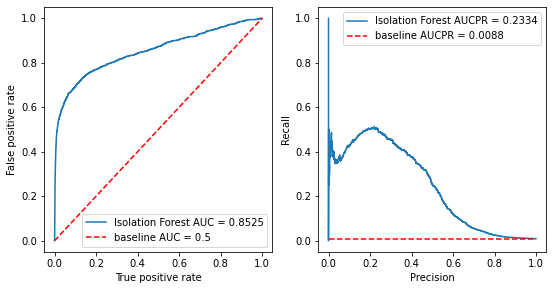

In [14]:
# Plot AUC and AUCPR curves
figure()
axes = prediction_summary(
    np.array(test_labels), anomaly_scores_mod, "Isolation Forest")

### Get anomalies in test set

In [15]:
# Filter to anomaly data in test set
test_df_anomaly = test_df.copy()
test_df_anomaly['ANOMALY'] = preds_mod
test_df_anomaly = test_df_anomaly[test_df_anomaly['ANOMALY'] == 1]

In [17]:
# Preview anomaly data
test_df_anomaly.head(15)

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,ANOMALY
1619975,133.87,0,1,6.0,12.0,34.0,137.716667,132.885833,125.035588,1.0,2.0,25.0,0.0,0.000000,0.000000,1
1619990,136.55,0,1,4.0,23.0,103.0,188.907500,179.363043,114.963592,1.0,5.0,25.0,0.0,0.000000,0.040000,1
1620001,137.80,0,1,1.0,7.0,26.0,137.800000,126.072857,109.840769,0.0,14.0,39.0,0.0,0.000000,0.000000,1
1620002,67.58,0,1,3.0,16.0,62.0,69.593333,64.790000,56.632419,0.0,9.0,27.0,0.0,0.888889,0.962963,1
1620018,49.40,0,1,5.0,32.0,111.0,69.726000,85.234063,84.794865,2.0,12.0,28.0,1.0,1.000000,0.428571,1
1620123,52.73,0,1,7.0,31.0,119.0,45.185714,44.980645,45.643109,5.0,16.0,57.0,0.0,0.000000,0.017544,1
1620146,108.80,0,1,3.0,14.0,76.0,87.733333,89.586429,89.118421,1.0,5.0,39.0,1.0,1.000000,0.128205,1
1620168,95.83,0,1,4.0,23.0,122.0,112.807500,106.533478,88.462049,1.0,4.0,16.0,0.0,0.000000,0.750000,1
1620198,109.99,0,1,3.0,17.0,88.0,134.313333,118.465294,102.533182,6.0,20.0,42.0,0.0,0.000000,0.000000,1
1620229,89.92,0,1,5.0,29.0,101.0,100.966000,78.401724,76.102376,0.0,5.0,27.0,0.0,1.000000,0.666667,1
